In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


c:\Users\ebehnia\AppData\Local\anaconda3\conda-meta\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [15]:
# Load the dataset
file_path = 'Resources\historical-property-sales-data.csv'
data = pd.read_csv(file_path)

# Loading Load the dataset and initial cleaning

In [16]:

# Check available columns in the dataset
print('Columns in the dataset:', data.columns.tolist())

# Dropping Unnecessary columns that exist in the DataFrame
columns_to_drop = ['PropertyID', 'taxkey', 'Address', 'CondoProject', 'District', 'Extwall']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=existing_columns_to_drop)

# Checking columns after dropping
print('Columns after dropping unnecessary columns:', data.columns.tolist())

# Handling missing values by filling numeric columns with zeros and categorical columns with a placeholder
data.fillna({
    'PropType': 'Unknown',
    'nbhd': 0,
    'Style': 'Unknown',
    'Stories': 0,
    'Year_Built': 0,
    'Rooms': 0,
    'FinishedSqft': 0,
    'Units': 0,
    'Bdrms': 0,
    'Fbath': 0,
    'Hbath': 0,
    'Lotsize': 0,
    'Sale_date': '1970-01-01',  # Placeholder date
    'Sale_price': '$0'
}, inplace=True)

# Normalizing date formats
data['Sale_date'] = pd.to_datetime(data['Sale_date'], errors='coerce')

# Removing special characters and converting to numeric
data['Sale_price'] = data['Sale_price'].replace('[\\$,]', '', regex=True).astype(float)
data['FinishedSqft'] = data['FinishedSqft'].replace('[,]', '', regex=True).astype(float)
data['Lotsize'] = data['Lotsize'].replace('[,]', '', regex=True).astype(float)

# Converting appropriate columns to numeric types
numeric_columns = ['nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Checking the columns again  after conversion
print('Columns after conversion:', data.columns.tolist())

# Function to keep only 'Residential' in 'PropType'
def filter_residential(df):
    return df[df['PropType'] == 'Residential']

# Function to drop rows where 'Sale_price' is under 80,000
def drop_low_prices(df, threshold=80000):
    return df[df['Sale_price'] >= threshold]

# Apply the filtering functions
data = filter_residential(data)
data = drop_low_prices(data)

# Convert non-numeric columns to numeric using pd.get_dummies()
data = pd.get_dummies(data)

# Dropping any remaining rows with NaN values resulting from type conversion
cleaned_data = data.dropna()

# Displaying the cleaned dataset
print(cleaned_data.head())


Columns in the dataset: ['PropertyID', 'PropType', 'taxkey', 'Address', 'CondoProject', 'District', 'nbhd', 'Style', 'Extwall', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price']
Columns after dropping unnecessary columns: ['PropType', 'nbhd', 'Style', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price']
Columns after conversion: ['PropType', 'nbhd', 'Style', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price']
      nbhd  Stories  Year_Built  Rooms  FinishedSqft  Units  Bdrms  Fbath  \
83   780.0      2.0      1930.0    5.0        1120.0      1    2.0    1.0   
144  240.0      2.0      1948.0    7.0        2200.0      1    4.0    2.0   
179  800.0      1.0      1929.0    4.0        1125.0      1    2.0    1.0   
207  240.0      2.0      1914.0    9.0        2555.0      1   

In [17]:


# Save the cleaned data to a new CSV file
cleaned_file_path = 'Resources\Cleanedd-historical-property-sales-data.csv'  # Adjust the path as needed
cleaned_data.to_csv(cleaned_file_path, index=False)


# Loading the cleaning data and checking columns (if not already done)

In [18]:
# Load the cleaned data for machine learning
cleaned_data = pd.read_csv(cleaned_file_path)

# Print the columns to check for the correct column names
print(cleaned_data.columns)


Index(['nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units',
       'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price',
       'PropType_Residential', 'Style_**', 'Style_AP 1', 'Style_Bi-Level',
       'Style_Cape Cod', 'Style_Colonial', 'Style_Contemporary',
       'Style_Cottage', 'Style_Dplx Bungalow', 'Style_Duplex N/S',
       'Style_Duplex O/S', 'Style_Duplex-Cottage', 'Style_Mansion',
       'Style_Milwaukee Bungalow', 'Style_Multiple Residential Bldgs',
       'Style_OBY', 'Style_Ranch', 'Style_Res O/S 1 Story',
       'Style_Res O/S 2sty +', 'Style_Res O/S A & 1/2', 'Style_Residence O/S',
       'Style_Residence O/S 2sty+', 'Style_Rm or Rooming House',
       'Style_Split Level', 'Style_Townhouse', 'Style_Triplex', 'Style_Tudor',
       'Style_Unknown'],
      dtype='object')


# Cleaning column names

In [19]:
# Clean column names by stripping any extra spaces
cleaned_data.columns = cleaned_data.columns.str.strip()

# Check the cleaned column names
print(cleaned_data.columns)


Index(['nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units',
       'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price',
       'PropType_Residential', 'Style_**', 'Style_AP 1', 'Style_Bi-Level',
       'Style_Cape Cod', 'Style_Colonial', 'Style_Contemporary',
       'Style_Cottage', 'Style_Dplx Bungalow', 'Style_Duplex N/S',
       'Style_Duplex O/S', 'Style_Duplex-Cottage', 'Style_Mansion',
       'Style_Milwaukee Bungalow', 'Style_Multiple Residential Bldgs',
       'Style_OBY', 'Style_Ranch', 'Style_Res O/S 1 Story',
       'Style_Res O/S 2sty +', 'Style_Res O/S A & 1/2', 'Style_Residence O/S',
       'Style_Residence O/S 2sty+', 'Style_Rm or Rooming House',
       'Style_Split Level', 'Style_Townhouse', 'Style_Triplex', 'Style_Tudor',
       'Style_Unknown'],
      dtype='object')


# Feature Engineering 

In [20]:
# Featuring engineering: Example of creating new features
cleaned_data['Age'] = 2024 - cleaned_data['Year_Built']
cleaned_data['Total_Bathrooms'] = cleaned_data['Fbath'] + 0.5 * cleaned_data['Hbath']

# Preparing the data for modeling
X = cleaned_data.drop(columns=['Sale_date', 'Sale_price'])
y = cleaned_data['Sale_price']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#  Train and evaluate an advanced model (Random Forest)

In [21]:
# Initializing the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating Mean Squared Error (MSE) for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

# Calculating Mean Absolute Error (MAE) for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest Mean Absolute Error: {mae_rf}')

# Calculation for the R-squared score for Random Forest
r2_score_rf = rf_model.score(X_test, y_test)
print(f'Random Forest R-squared: {r2_score_rf}')
print(f'Random Forest R-squared as percentage: {r2_score_rf * 100}%')


Random Forest Mean Squared Error: 3082239124.083184
Random Forest Mean Absolute Error: 33673.79544243649
Random Forest R-squared: 0.7200277634532132
Random Forest R-squared as percentage: 72.00277634532132%


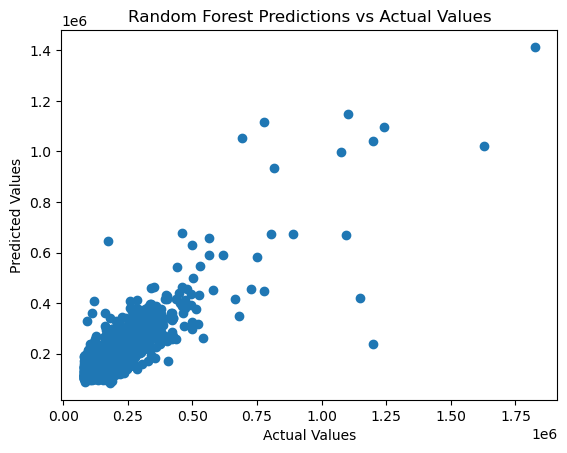

In [9]:
# Plotting the predictions vs actual values for Random Forest
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Predictions vs Actual Values')
plt.show()
